### Data Preprocessing

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-10 normalization constants
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Standard preprocessing for val/test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Loading full CIFAR-10 training data (50k images)
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Total dataset size (50,000 from train=True)
total_size = len(full_dataset)  # 50,000
train_size = int(0.70 * total_size)  # 35,000
val_size = int(0.15 * total_size)    # 7,500
test_size = total_size - train_size - val_size  # 7,500

# Splitting the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Changing transform for val/test (no augmentation)
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


### Implementing a basic CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Output: 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32x16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64x8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 128x4x4
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)  # 10 classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [ ]:
import torch.optim as optim

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100. * correct / total

def train_model(model, train_loader, val_loader, epochs=15, lr=0.001):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_acc = evaluate_model(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {100. * correct / total:.2f}%, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses

In [ ]:
model = BasicCNN()
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=13, lr=0.001)

Epoch [1/13] - Train Loss: 1.4831, Val Loss: 1.1562, Train Acc: 45.98%, Val Acc: 58.27%
Epoch [2/13] - Train Loss: 1.1368, Val Loss: 0.9998, Train Acc: 59.59%, Val Acc: 64.45%
Epoch [3/13] - Train Loss: 1.0100, Val Loss: 0.8903, Train Acc: 64.38%, Val Acc: 68.92%
Epoch [4/13] - Train Loss: 0.9140, Val Loss: 0.8525, Train Acc: 67.87%, Val Acc: 69.20%
Epoch [5/13] - Train Loss: 0.8480, Val Loss: 0.9145, Train Acc: 70.39%, Val Acc: 69.07%
Epoch [6/13] - Train Loss: 0.7868, Val Loss: 0.8220, Train Acc: 72.60%, Val Acc: 71.73%
Epoch [7/13] - Train Loss: 0.7357, Val Loss: 0.7265, Train Acc: 74.36%, Val Acc: 74.68%
Epoch [8/13] - Train Loss: 0.6777, Val Loss: 0.7638, Train Acc: 76.33%, Val Acc: 74.00%
Epoch [9/13] - Train Loss: 0.6338, Val Loss: 0.7210, Train Acc: 77.76%, Val Acc: 75.52%
Epoch [10/13] - Train Loss: 0.5960, Val Loss: 0.7822, Train Acc: 78.84%, Val Acc: 74.19%
Epoch [11/13] - Train Loss: 0.5537, Val Loss: 0.7584, Train Acc: 80.40%, Val Acc: 75.08%
Epoch [12/13] - Train Loss: 0.

### Plotting Training and Validation Loss Curves




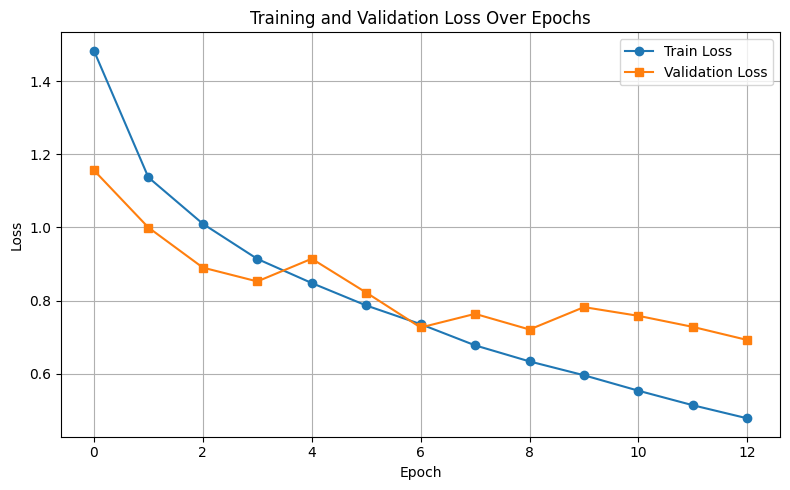

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Implementing LeNet and AlexNet

Using device: cuda
Dataset sizes - Train: 35000, Validation: 7500, Test: 7500
CIFAR-10 Classification with LeNet and AlexNet

LeNet Parameters: 83,126
AlexNet Parameters: 35,855,178

Training LeNet
Epoch [5/20], Train Loss: 1.0155, Val Loss: 1.1118, Val Acc: 61.08%
Epoch [10/20], Train Loss: 0.7541, Val Loss: 1.1248, Val Acc: 62.72%
Epoch [15/20], Train Loss: 0.5409, Val Loss: 1.1677, Val Acc: 63.75%
Epoch [20/20], Train Loss: 0.4957, Val Loss: 1.2247, Val Acc: 63.64%
Best Validation Accuracy: 63.89%

Training AlexNet
Epoch [5/20], Train Loss: 0.7660, Val Loss: 0.7756, Val Acc: 72.59%
Epoch [10/20], Train Loss: 0.3682, Val Loss: 0.6742, Val Acc: 77.12%
Epoch [15/20], Train Loss: 0.1404, Val Loss: 0.6960, Val Acc: 79.91%
Epoch [20/20], Train Loss: 0.0935, Val Loss: 0.7556, Val Acc: 80.27%
Best Validation Accuracy: 80.28%

Model Evaluation

LeNet Results:
Test Accuracy: 63.59%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.65      0.70

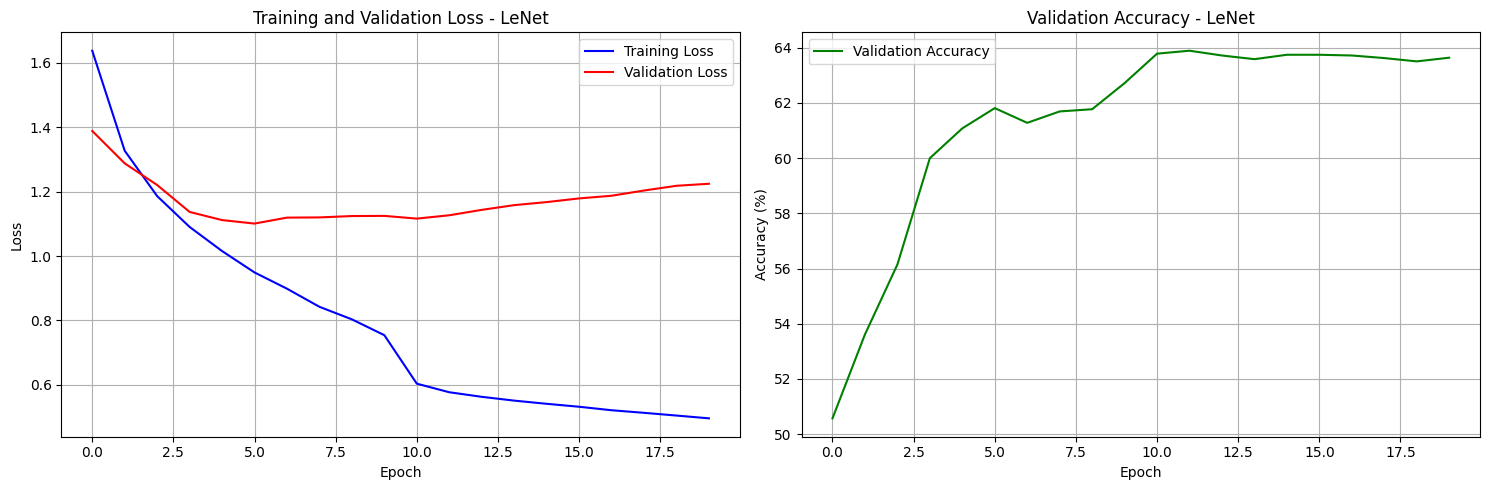

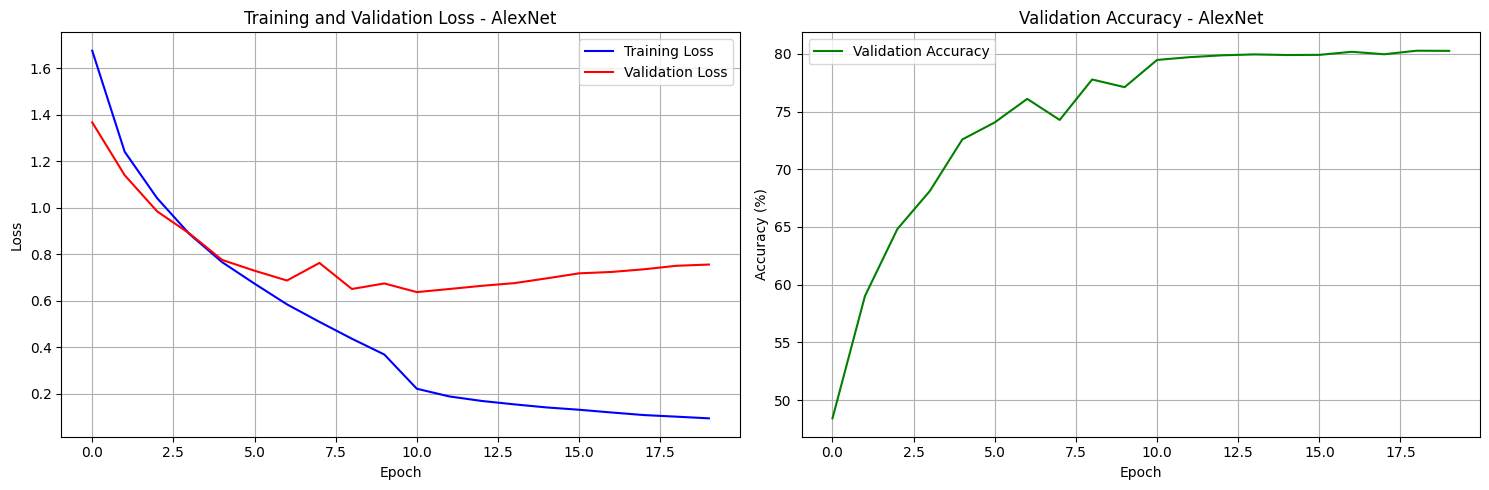

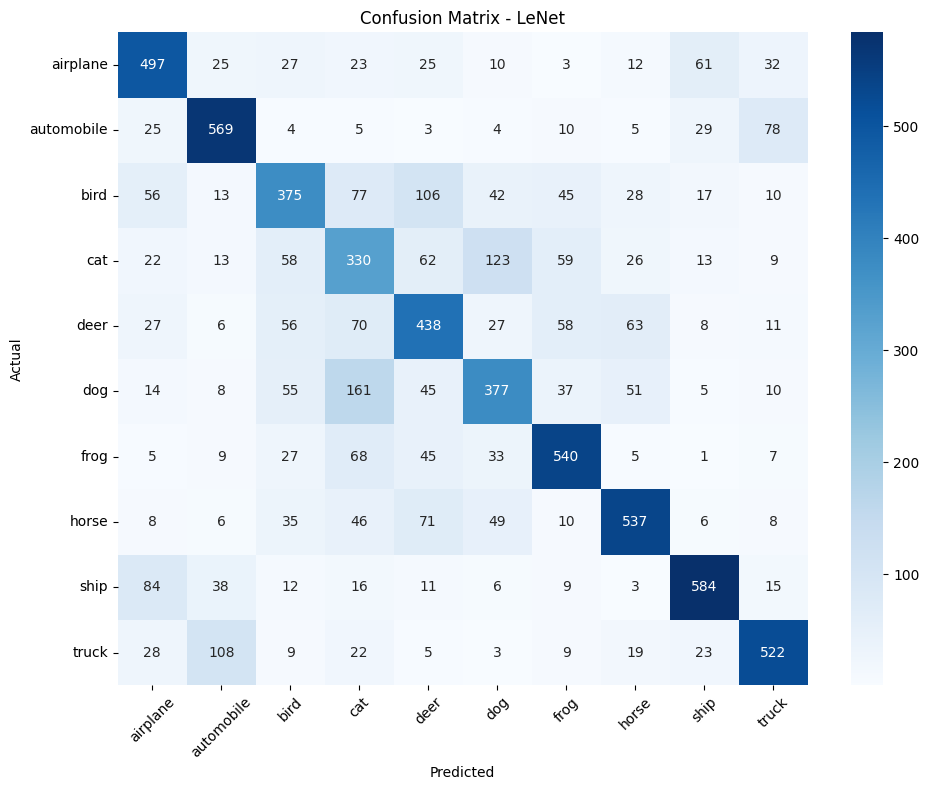

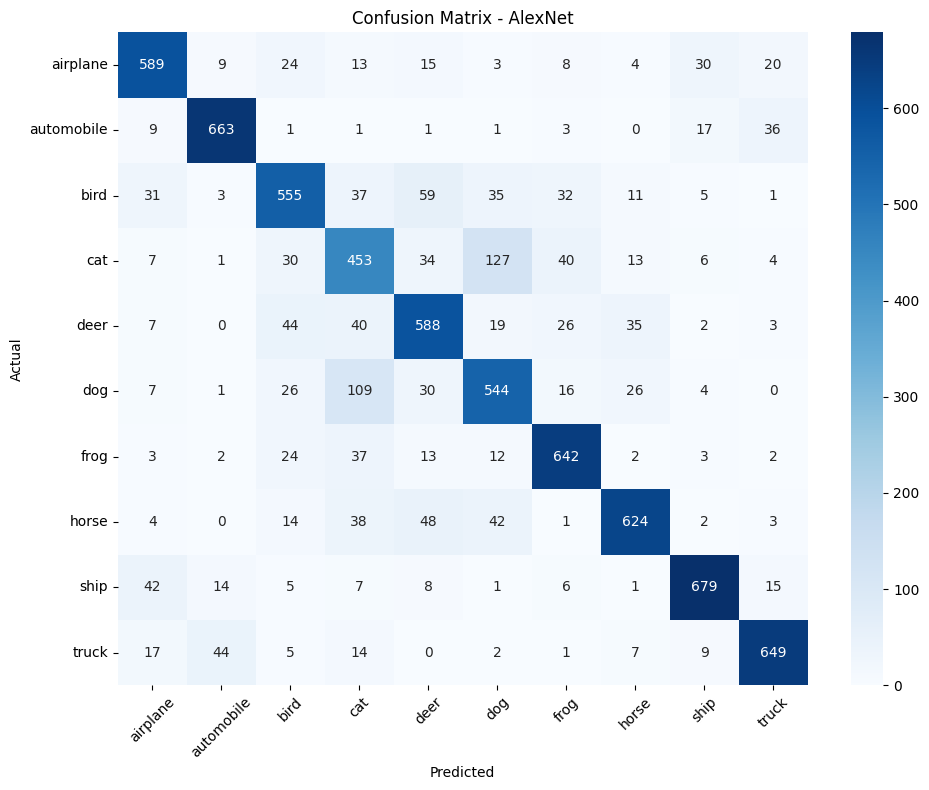

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# CIFAR-10 normalization constants
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Standard preprocessing for val/test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Loading full CIFAR-10 training data (50k images)
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Total dataset size (50,000 from train=True)
total_size = len(full_dataset)  # 50,000
train_size = int(0.70 * total_size)  # 35,000
val_size = int(0.15 * total_size)    # 7,500
test_size = total_size - train_size - val_size  # 7,500

# Splitting the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Changing transform for val/test (no augmentation)
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}, Test: {test_size}")

# LeNet Model Implementation
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # Activation and pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# AlexNet Model Implementation
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Training function
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        scheduler.step()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Saving the best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    # Loading the best model
    model.load_state_dict(best_model_state)
    print(f'Best Validation Accuracy: {best_val_acc:.2f}%')

    return train_losses, val_losses, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader, model_name):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculating accuracy
    accuracy = 100 * correct / total

    # Converting to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=CIFAR10_CLASSES))

    return all_predictions, all_labels, all_probabilities, accuracy

# Plotting functions
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(y_true, y_prob, model_name):
    # Binarizing the output
    y_true_bin = label_binarize(y_true, classes=range(10))
    n_classes = y_true_bin.shape[1]

    # Computing ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Computing micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plotting ROC curves
    plt.figure(figsize=(12, 8))

    # Plotting micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plotting ROC curves for each class
    colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{CIFAR10_CLASSES[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'roc_curves_{model_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return roc_auc

def plot_precision_recall_curves(y_true, y_prob, model_name):
    # Binarizing the output
    y_true_bin = label_binarize(y_true, classes=range(10))
    n_classes = y_true_bin.shape[1]

    # Computing Precision-Recall curve and average precision for each class
    precision = dict()
    recall = dict()
    avg_precision = dict()

    plt.figure(figsize=(12, 8))

    colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
        avg_precision[i] = auc(recall[i], precision[i])

        plt.plot(recall[i], precision[i], color=color, lw=2,
                label=f'{CIFAR10_CLASSES[i]} (AP = {avg_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves - {model_name}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'precision_recall_curves_{model_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return avg_precision

def plot_training_history(train_losses, val_losses, val_accuracies, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title(f'Training and Validation Loss - {model_name}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plotting validation accuracy
    ax2.plot(val_accuracies, label='Validation Accuracy', color='green')
    ax2.set_title(f'Validation Accuracy - {model_name}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'training_history_{model_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
if __name__ == "__main__":
    print("="*60)
    print("CIFAR-10 Classification with LeNet and AlexNet")
    print("="*60)

    # Initializing models
    lenet = LeNet(num_classes=10).to(device)
    alexnet = AlexNet(num_classes=10).to(device)

    # Printing model summaries
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nLeNet Parameters: {count_parameters(lenet):,}")
    print(f"AlexNet Parameters: {count_parameters(alexnet):,}")

    # Training LeNet
    print("\n" + "="*40)
    print("Training LeNet")
    print("="*40)
    lenet_train_losses, lenet_val_losses, lenet_val_accs = train_model(
        lenet, train_loader, val_loader, num_epochs=20, learning_rate=0.001
    )

    # Training AlexNet
    print("\n" + "="*40)
    print("Training AlexNet")
    print("="*40)
    alexnet_train_losses, alexnet_val_losses, alexnet_val_accs = train_model(
        alexnet, train_loader, val_loader, num_epochs=20, learning_rate=0.0001
    )

    # Evaluating models
    print("\n" + "="*40)
    print("Model Evaluation")
    print("="*40)

    # LeNet Evaluation
    lenet_preds, lenet_labels, lenet_probs, lenet_acc = evaluate_model(lenet, test_loader, "LeNet")

    # AlexNet Evaluation
    alexnet_preds, alexnet_labels, alexnet_probs, alexnet_acc = evaluate_model(alexnet, test_loader, "AlexNet")

    # Generating visualizations
    print("\n" + "="*40)
    print("Generating Visualizations")
    print("="*40)

    # Training history plots
    plot_training_history(lenet_train_losses, lenet_val_losses, lenet_val_accs, "LeNet")
    plot_training_history(alexnet_train_losses, alexnet_val_losses, alexnet_val_accs, "AlexNet")

    # Confusion matrices
    plot_confusion_matrix(lenet_labels, lenet_preds, "LeNet")
    plot_confusion_matrix(alexnet_labels, alexnet_preds, "AlexNet")

    # ROC curves
    lenet_roc_auc = plot_roc_curves(lenet_labels, lenet_probs, "LeNet")
    alexnet_roc_auc = plot_roc_curves(alexnet_labels, alexnet_probs, "AlexNet")

    # Precision-Recall curves
    lenet_avg_precision = plot_precision_recall_curves(lenet_labels, lenet_probs, "LeNet")
    alexnet_avg_precision = plot_precision_recall_curves(alexnet_labels, alexnet_probs, "AlexNet")

    # Summary comparison
    print("\n" + "="*60)
    print("FINAL COMPARISON SUMMARY")
    print("="*60)
    print(f"LeNet Test Accuracy: {lenet_acc:.2f}%")
    print(f"AlexNet Test Accuracy: {alexnet_acc:.2f}%")

    print(f"\nLeNet Micro-Average ROC-AUC: {lenet_roc_auc['micro']:.4f}")
    print(f"AlexNet Micro-Average ROC-AUC: {alexnet_roc_auc['micro']:.4f}")

    lenet_mean_ap = np.mean(list(lenet_avg_precision.values()))
    alexnet_mean_ap = np.mean(list(alexnet_avg_precision.values()))
    print(f"\nLeNet Mean Average Precision: {lenet_mean_ap:.4f}")
    print(f"AlexNet Mean Average Precision: {alexnet_mean_ap:.4f}")

    print(f"\nLeNet Parameters: {count_parameters(lenet):,}")
    print(f"AlexNet Parameters: {count_parameters(alexnet):,}")
